# Maîtrise des problèmes d'ajustement de modèle (Chap 18)

## Répartition entre jeu d'entraînement et jeu de test

In [1]:
from sklearn.datasets import load_boston
boston = load_boston()
X, y = boston.data, boston.target
print(X.shape, y.shape)

(506, 13) (506,)


In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
regression = LinearRegression()
regression.fit(X,y)
print('Erreur moindres carrés: %.2f' % mean_squared_error(
    y_true=y, y_pred=regression.predict(X)))

Erreur moindres carrés: 21.90


In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=5)
print(X_train.shape, X_test.shape)

(354, 13) (152, 13)


In [4]:
regression.fit(X_train,y_train)
print('Erreur Entraînement moindres carrés: %.2f' % mean_squared_error(
    y_true=y_train, y_pred=regression.predict(X_train)))

Erreur Entraînement moindres carrés: 19.07


In [5]:
print('Erreur Test moindres carrés: %.2f' % mean_squared_error(
    y_true=y_test, y_pred=regression.predict(X_test)))

Erreur Test moindres carrés: 30.70


In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=6)
regression.fit(X_train,y_train)
print('Erreur Entraînement moindres carrés: %.2f' % mean_squared_error(
    y_true=y_train, y_pred=regression.predict(X_train)))
print('Erreur Test         moindres carrés: %.2f' % mean_squared_error(
    y_true=y_test, y_pred=regression.predict(X_test)))

Erreur Entraînement moindres carrés: 19.48
Erreur Test         moindres carrés: 28.33


# Validation croisée

## Validation croisée sur k-plis (k-fold)

In [7]:
from sklearn.model_selection import cross_val_score, KFold
import numpy as np
crossvalidation = KFold(n_splits=10, shuffle=True, random_state=1)
scores = cross_val_score(regression, X, y, 
    scoring='neg_mean_squared_error', cv=crossvalidation, n_jobs=1)
print('Plis: %i, Erreur moindres carrés: %.2f Ecart-type: %.2f' % 
      (len(scores),np.mean(np.abs(scores)),np.std(scores)))

Plis: 10, Erreur moindres carrés: 23.76 Ecart-type: 12.13


## Stratification des échantillons pour les données complexes

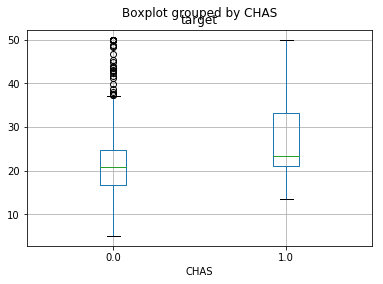

In [8]:
%matplotlib inline
import pandas as pd
df = pd.DataFrame(X, columns=boston.feature_names)
df['target'] = y
df.boxplot('target', by='CHAS', return_type='axes');

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import mean_squared_error
strata = StratifiedShuffleSplit(n_splits=3, 
                                test_size=0.35, 
                                random_state=0)
scores = list()
for train_index, test_index in strata.split(X, X[:,3]):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    regression.fit(X_train, y_train)
    scores.append(mean_squared_error(y_true=y_test, 
                       y_pred=regression.predict(X_test)))
print('%i plis cv Erreur moindres carrés: %.2f Ecart-type: %.2f' % 
      (len(scores),np.mean(np.abs(scores)),np.std(scores)))

3 plis cv Erreur moindres carrés: 24.30 Ecart-type: 3.99


# Stratégie de sélection des variables

## Sélection par mesures univariées

In [10]:
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import f_regression
Selector_f = SelectPercentile(f_regression, percentile=25)
Selector_f.fit(X, y)
for n,s in zip(boston.feature_names,Selector_f.scores_):
    print('F-score: %3.2f\t pour la caractéristique %s ' % (s,n))

F-score: 88.15	 pour la caractéristique CRIM 
F-score: 75.26	 pour la caractéristique ZN 
F-score: 153.95	 pour la caractéristique INDUS 
F-score: 15.97	 pour la caractéristique CHAS 
F-score: 112.59	 pour la caractéristique NOX 
F-score: 471.85	 pour la caractéristique RM 
F-score: 83.48	 pour la caractéristique AGE 
F-score: 33.58	 pour la caractéristique DIS 
F-score: 85.91	 pour la caractéristique RAD 
F-score: 141.76	 pour la caractéristique TAX 
F-score: 175.11	 pour la caractéristique PTRATIO 
F-score: 63.05	 pour la caractéristique B 
F-score: 601.62	 pour la caractéristique LSTAT 


## Approche de sélection arrière ou avide (greedy)

In [11]:
from sklearn.feature_selection import RFECV
selector = RFECV(estimator=regression, 
                 cv=10, 
                 scoring='neg_mean_squared_error')
selector.fit(X, y)
print("Nombre optimal de caractéristiques: %d" 
      % selector.n_features_)

Nombre optimal de caractéristiques: 6


In [12]:
print(boston.feature_names[selector.support_])

['CHAS' 'NOX' 'RM' 'DIS' 'PTRATIO' 'LSTAT']


# Optimisation des hyper-paramètres

In [13]:
import numpy as np
from sklearn.datasets import load_iris
iris = load_iris()
X, y = iris.data, iris.target

## Recherche combinatoire systématique (grid)

In [14]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=5, 
      weights='uniform', metric= 'minkowski', p=2)

In [15]:
grid = {'n_neighbors': range(1,11), 
        'weights': ['uniform', 'distance'], 'p': [1,2]}
print ('Nombre de modèles testés: %i' 
       % np.prod([len(grid[element]) for element in grid]))
score_metric = 'accuracy'

Nombre de modèles testés: 40


In [16]:
from sklearn.model_selection import cross_val_score
print('Témoin (baseline) avec paramètres par défaut: %.3f' 
      % np.mean(cross_val_score(classifier, X, y, 
                cv=10, scoring=score_metric, n_jobs=1)))

Témoin (baseline) avec paramètres par défaut: 0.967


In [17]:
from sklearn.model_selection import GridSearchCV
search = GridSearchCV(estimator=classifier, 
                      param_grid=grid, 
                      scoring=score_metric, 
                      n_jobs=1, 
                      refit=True, 
                      return_train_score=True, 
                      cv=10)
search.fit(X,y)

GridSearchCV(cv=10, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': range(1, 11), 'weights': ['uniform', 'distance'], 'p': [1, 2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [18]:
print('Meilleurs paramètres: %s' % search.best_params_)
print('Précision CV des meilleurs paramètres: %.3f' % 
      search.best_score_)

Meilleurs paramètres: {'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}
Précision CV des meilleurs paramètres: 0.973


In [19]:
print(search.cv_results_)

{'mean_fit_time': array([0.00312545, 0.        , 0.        , 0.        , 0.00156307,
       0.0015625 , 0.00156262, 0.0015625 , 0.00312507, 0.0015624 ,
       0.        , 0.00156243, 0.        , 0.        , 0.        ,
       0.00156269, 0.0015624 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00156245, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00156238, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00156245, 0.00156248]), 'std_fit_time': array([0.00625091, 0.        , 0.        , 0.        , 0.00468922,
       0.0046875 , 0.00468786, 0.0046875 , 0.00625014, 0.00468721,
       0.        , 0.00468729, 0.        , 0.        , 0.        ,
       0.00468807, 0.00468721, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00468736, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.     

In [20]:
from sklearn.model_selection import validation_curve
model = KNeighborsClassifier(weights='uniform', 
                             metric= 'minkowski', p=1)
train, test = validation_curve(model, X, y, 
                               param_name='n_neighbors', 
                               param_range=range(1, 11), 
                               cv=10, scoring='accuracy', 
                               n_jobs=1)

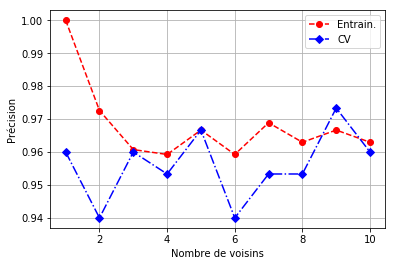

In [21]:
import matplotlib.pyplot as plt
mean_train  = np.mean(train,axis=1)
mean_test   = np.mean(test,axis=1)
plt.plot(range(1,11), mean_train,'ro--', label='Entrain.')
plt.plot(range(1,11), mean_test,'bD-.', label='CV')
plt.grid()
plt.xlabel('Nombre de voisins')
plt.ylabel('Précision')
plt.legend(loc='upper right', numpoints= 1)
plt.show()


## Recherches aléatoires

In [22]:
from sklearn.model_selection import RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=classifier, 
                    param_distributions=grid, n_iter=10, 
    scoring=score_metric, n_jobs=1, refit=True, cv=10, )
random_search.fit(X, y)

RandomizedSearchCV(cv=10, error_score='raise',
          estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'n_neighbors': range(1, 11), 'weights': ['uniform', 'distance'], 'p': [1, 2]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='accuracy', verbose=0)

In [23]:
print('Meilleurs paramètres: %s' % random_search.best_params_)
print('Précision CV des meilleurs paramètres: %.3f' % 
      random_search.best_score_)

Meilleurs paramètres: {'weights': 'distance', 'p': 2, 'n_neighbors': 10}
Précision CV des meilleurs paramètres: 0.973
